In [2]:
import pandas as pd
from collections import defaultdict

from workflow.external.gtdb_metadata import GtdbMetadataR207
from workflow.external.gtdb_metadata import GtdbMetadataR207Full
from workflow.gunc.aggregate_max_css_level_gunc import AggregateMaxCssLevelGtdbR95

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from workflow.gunc.aggregate_max_css_level_merged import AggregateMaxCssLevelMerged
from workflow.gunc.aggregate_max_css_level_progenomes import AggregateMaxCssLevelProGenomes


In [3]:
def get_df():
    df_pro = AggregateMaxCssLevelProGenomes().output().read_cached()
    df_gtdb = AggregateMaxCssLevelGtdbR95().output().read_cached()
    df_meta = GtdbMetadataR207Full().output().read_cached()

    df_merged = df_pro.merge(df_gtdb, how='inner', left_index=True, right_index=True, suffixes=('_pro', '_gtdb'))
    df_merged = df_merged.merge(df_meta, how='inner', left_index=True, right_index=True)
    return df_merged

DF = get_df()

[23/11/2022 08:16:04] - 11.8MiB = /srv/home/uqamussi/projects/gunc-chimeras/output/gunc/gunc_progenomes_max_css_level.h5 -> /tmp/gunc-cache/srv/home/uqamussi/projects/gunc-chimeras/output/gunc/gunc_progenomes_max_css_level.h5
[23/11/2022 08:16:06] - 9.7MiB = /srv/home/uqamussi/projects/gunc-chimeras/output/gunc/gunc_gtdb_95_max_css_level.h5 -> /tmp/gunc-cache/srv/home/uqamussi/projects/gunc-chimeras/output/gunc/gunc_gtdb_95_max_css_level.h5
[23/11/2022 08:16:08] - 215.3MiB = /srv/home/uqamussi/projects/gunc-chimeras/output/external/gtdb_r207_metadata_full.h5 -> /tmp/gunc-cache/srv/home/uqamussi/projects/gunc-chimeras/output/external/gtdb_r207_metadata_full.h5


In [4]:
print(DF.shape)
DF.head()

(317542, 140)


,n_genes_called_pro,n_genes_mapped_pro,n_contigs_pro,taxonomic_level_pro,proportion_genes_retained_in_major_clades_pro,genes_retained_index_pro,clade_separation_score_pro,contamination_portion_pro,n_effective_surplus_clades_pro,mean_hit_identity_pro,...,trna_aa_count,trna_count,trna_selenocysteine_count,domain,phylum,class,order,family,genus,species
gid,,,,,,,,,,,,,,,,,,,,,
GCA_000006155.2,5745,5627,3,kingdom,1.0,0.98,0.0,0.0,0.0,0.97,...,16,31,0,d__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae_G,g__Bacillus_A,s__Bacillus_A anthracis
GCA_000007325.1,2022,2016,1,kingdom,1.0,1.00,0.0,0.0,0.0,0.98,...,20,47,0,d__Bacteria,p__Fusobacteriota,c__Fusobacteriia,o__Fusobacteriales,f__Fusobacteriaceae,g__Fusobacterium,s__Fusobacterium nucleatum
GCA_000007385.1,4831,4724,1,kingdom,1.0,0.98,0.0,0.0,0.0,0.98,...,20,53,0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Xanthomonadales,f__Xanthomonadaceae,g__Xanthomonas,s__Xanthomonas oryzae
GCA_000008085.1,583,545,1,kingdom,1.0,0.93,0.0,0.0,0.0,0.98,...,17,38,0,d__Archaea,p__Nanoarchaeota,c__Nanoarchaeia,o__Nanoarchaeales,f__Nanoarchaeaceae,g__Nanoarchaeum,s__Nanoarchaeum equitans
GCA_000008885.1,646,643,2,kingdom,1.0,1.00,0.0,0.0,0.0,0.97,...,20,34,0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales_A,f__Enterobacteriaceae_A,g__Wigglesworthia,s__Wigglesworthia glossinidia_A


In [10]:
def basic_stats():

    # Set masks
    mask_failed_pro = DF['pass.GUNC_pro'] == False
    mask_failed_gtdb = DF['pass.GUNC_gtdb'] == False
    mask_failed_all = mask_failed_pro | mask_failed_gtdb
    mask_sp_reps = DF['gtdb_representative'] == 't'
    mask_non_sp_reps = DF['gtdb_representative'] == 'f'


    print(f'Found {sum(mask_sp_reps):,} species reps')

    # Set slices
    df_failed_pro = DF[mask_failed_pro]
    df_failed_gtdb = DF[mask_failed_gtdb]
    df_failed_all = DF[mask_failed_all]
    df_sp_reps = DF[mask_sp_reps]
    df_non_sp_reps = DF[mask_non_sp_reps]

    # Which were common?
    n_intersect = len(set(df_failed_pro.index).intersection(df_failed_gtdb.index))
    print(f'There were {n_intersect:,} gids that failed in both progenomes and r95')

    # Basic numbers of how many failed
    prop_fail_pro = len(df_failed_pro) / len(DF)
    prop_fail_gtdb = len(df_failed_gtdb) / len(DF)
    prop_fail_all = len(df_failed_all) / len(DF)
    print(f'{len(df_failed_pro):,} / {len(DF):,} ({prop_fail_pro:.2%}) genomes failed GUNC (progenomes)')
    print(f'{len(df_failed_gtdb):,} / {len(DF):,} ({prop_fail_gtdb:.2%}) genomes failed GUNC (GTDB R95)')
    print(f'{len(df_failed_all):,} / {len(DF):,} ({prop_fail_all:.2%}) genomes failed GUNC (all)')

    # How about species reps
    df_failed_and_sp_rep_pro = DF[mask_failed_pro & mask_sp_reps]
    df_failed_and_sp_rep_gtdb = DF[mask_failed_gtdb & mask_sp_reps]
    df_failed_and_sp_rep_all = DF[mask_failed_all & mask_sp_reps]

    # Break it down into domain
    set_bac_gids = set(DF[DF['domain'] == 'd__Bacteria'].index)
    set_arc_gids = set(DF[DF['domain'] == 'd__Archaea'].index)
    set_rep_gids = set(df_sp_reps.index)
    set_arc_rep_gids = set_arc_gids.intersection(set_rep_gids)
    set_bac_rep_gids = set_bac_gids.intersection(set_rep_gids)

    set_arc_rep_gids_fail = set_arc_rep_gids.intersection(set(df_failed_all.index))
    set_bac_rep_gids_fail = set_bac_rep_gids.intersection(set(df_failed_all.index))

    set_non_rep_fail_gids = set(df_non_sp_reps.index).intersection(set(df_failed_all.index))
    set_arc_non_rep_fail_gids = set_non_rep_fail_gids.intersection(set_arc_gids)
    set_bac_non_rep_fail_gids = set_non_rep_fail_gids.intersection(set_bac_gids)


    print()
    print(f'There are {len(set_rep_gids):,} species representatives in R207')
    print(f'There are {len(set_arc_gids):,} archaeal genomes in R207 ({len(set_arc_rep_gids):,} reps)')
    print(f'There are {len(set_bac_gids):,} bacterial genomes in R207 ({len(set_bac_rep_gids):,} reps)')

    print()

    print(f'{len(df_failed_and_sp_rep_pro):,} of the {len(df_failed_pro):,} GUNC failed genomes '
          f'({len(df_failed_and_sp_rep_pro) / len(df_failed_pro):.2%}) are species reps, '
          f'i.e. {len(df_failed_and_sp_rep_pro) / len(df_sp_reps):.2%} of the species reps failed GUNC (progenomes)')

    print(f'{len(df_failed_and_sp_rep_gtdb):,} of the {len(df_failed_gtdb):,} GUNC failed genomes '
          f'({len(df_failed_and_sp_rep_gtdb) / len(df_failed_gtdb):.2%}) are species reps, '
          f'i.e. {len(df_failed_and_sp_rep_gtdb) / len(df_sp_reps):.2%} of the species reps failed GUNC (GTDB R95)')

    print(f'{len(df_failed_and_sp_rep_all):,} of the {len(df_failed_all):,} GUNC failed genomes '
          f'({len(df_failed_and_sp_rep_all) / len(df_failed_all):.2%}) are species reps, '
          f'i.e. {len(df_failed_and_sp_rep_all) / len(df_sp_reps):.2%} of the species reps failed GUNC (all)')

    print(f'{len(set_arc_rep_gids_fail):,} archaeal representative genomes failed (all)')
    print(f'{len(set_bac_rep_gids_fail):,} bacterial representative genomes failed (all)')

    print(f'{len(set_non_rep_fail_gids):,} non reps failed (all)')
    print(f'{len(set_arc_non_rep_fail_gids):,} non rep arc gids failed (all)')
    print(f'{len(set_bac_non_rep_fail_gids):,} non rep bac gids failed (all)')



    return
basic_stats()


Found 65,703 species reps
There were 10,413 gids that failed in both progenomes and r95
17,278 / 317,542 (5.44%) genomes failed GUNC (progenomes)
28,858 / 317,542 (9.09%) genomes failed GUNC (GTDB R95)
35,723 / 317,542 (11.25%) genomes failed GUNC (all)

There are 65,703 species representatives in R207
There are 6,062 archaeal genomes in R207 (3,412 reps)
There are 311,480 bacterial genomes in R207 (62,291 reps)

2,568 of the 17,278 GUNC failed genomes (14.86%) are species reps, i.e. 3.91% of the species reps failed GUNC (progenomes)
3,348 of the 28,858 GUNC failed genomes (11.60%) are species reps, i.e. 5.10% of the species reps failed GUNC (GTDB R95)
4,836 of the 35,723 GUNC failed genomes (13.54%) are species reps, i.e. 7.36% of the species reps failed GUNC (all)
311 archaeal representative genomes failed (all)
4,525 bacterial representative genomes failed (all)
30,887 non reps failed (all)
566 non rep arc gids failed (all)
30,321 non rep bac gids failed (all)


In [5]:


def sp_reps_that_failed():

    # Set masks
    mask_failed_pro = DF['pass.GUNC_pro'] == False
    mask_failed_gtdb = DF['pass.GUNC_gtdb'] == False
    mask_failed_all = mask_failed_pro | mask_failed_gtdb
    mask_sp_reps = DF['gtdb_representative'] == 't'

    # Set slices
    df_failed_pro = DF[mask_failed_pro & mask_sp_reps]
    df_failed_gtdb = DF[mask_failed_gtdb & mask_sp_reps]
    df_failed_all = DF[mask_failed_all & mask_sp_reps]

    d_domain = Counter(df_failed_all['domain'])
    print(d_domain)

    d_phylum = Counter(df_failed_all['gtdb_taxonomy'].apply(lambda x: ';'.join(x.split(';')[0:6])))

    i = 0
    for k, v in sorted(d_phylum.items(), key=lambda x: x[1], reverse=True):
        if k.startswith('d__Bacteria'):
            print(f'{k} ({v:,})')
            i += 1

        if i > 20:
            print('...')
            break



    return

sp_reps_that_failed()



Counter({'d__Bacteria': 4525, 'd__Archaea': 311})
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella (34)
d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella (30)
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__UBA932;g__Cryptobacteroides (29)
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Pelagibacterales;f__Pelagibacteraceae;g__Pelagibacter (28)
d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Nanopelagicales;f__Nanopelagicaceae;g__Planktophila (27)
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium (24)
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__HIMB59;f__GCA-002718135;g__AG-337-I02 (19)
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Chitinophagaceae;g__Sediminibacterium (17)
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Novosphingo

35723


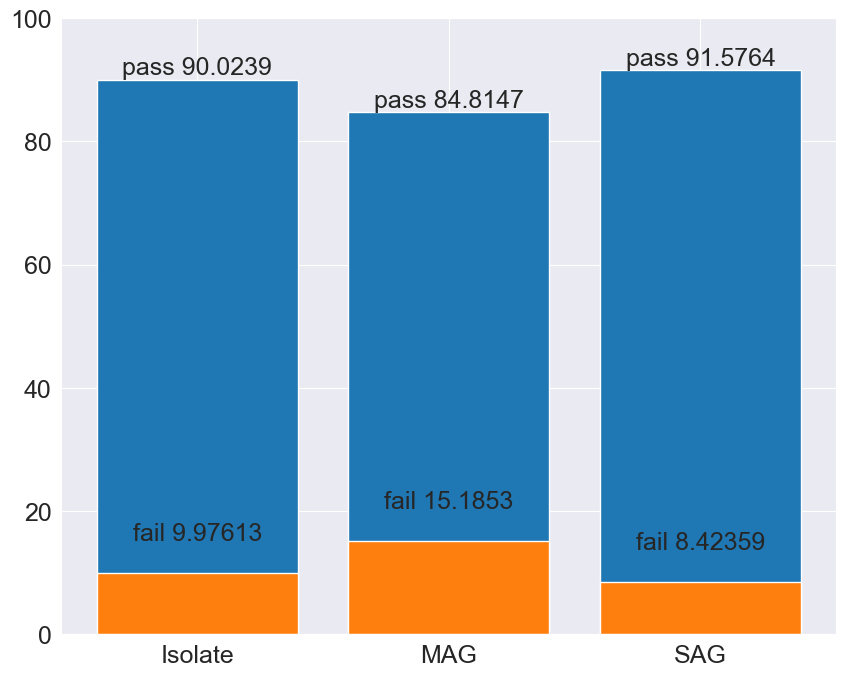

In [4]:
def pass_vs_fail_category():

    # Set masks
    mask_failed_pro = DF['pass.GUNC_pro'] == False
    mask_failed_gtdb = DF['pass.GUNC_gtdb'] == False

    mask_failed_all = mask_failed_pro | mask_failed_gtdb
    mask_pass_all = ~mask_failed_all

    df_failed_all = DF[mask_failed_all]
    df_pass_all = DF[mask_pass_all]

    print(len(df_failed_all))

    all_counts = Counter(df_pass_all['ncbi_genome_category'])
    all_data = {
        'Isolate': all_counts['none'] + all_counts['derived from environmental sample'],
        # 'ENV': all_counts['derived from environmental sample'],
        'MAG': all_counts['derived from metagenome'],
        'SAG': all_counts['derived from single cell'],
    }

    fail_counts = Counter(df_failed_all['ncbi_genome_category'])
    fail_data = {
        'Isolate': fail_counts['none'] + fail_counts['derived from environmental sample'],
        # 'ENV': fail_counts['derived from environmental sample'],
        'MAG': fail_counts['derived from metagenome'],
        'SAG': fail_counts['derived from single cell'],
    }


    all_data_norm = {k:  v / (v + fail_data[k]) * 100 for k, v in all_data.items()}
    fail_data_norm = {k: v/ (v + all_data[k]) * 100 for k, v in fail_data.items()}

    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots( figsize=(10, 8))

    # ax.set_ylabel('Count')
    # ax.set_xlabel('NCBI Genome Category')
    bars = ax.bar(all_data_norm.keys(), all_data_norm.values(), label='pass')
    fail_bars = ax.bar(fail_data_norm.keys(), fail_data_norm.values(), label='fail')
    plt.bar_label(bars, fmt='pass %g')
    plt.bar_label(fail_bars, padding=20, fmt='fail %g')

    ax.set_ylim(0, 100)

    # plt.title('NCBI genome category for GUNC pass/fail genomes')


    plt.rcParams.update({'font.size': 12})
    plt.rcParams['svg.fonttype'] = 'none'
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    plt.savefig('/tmp/category.svg')

    return

pass_vs_fail_category()

28858


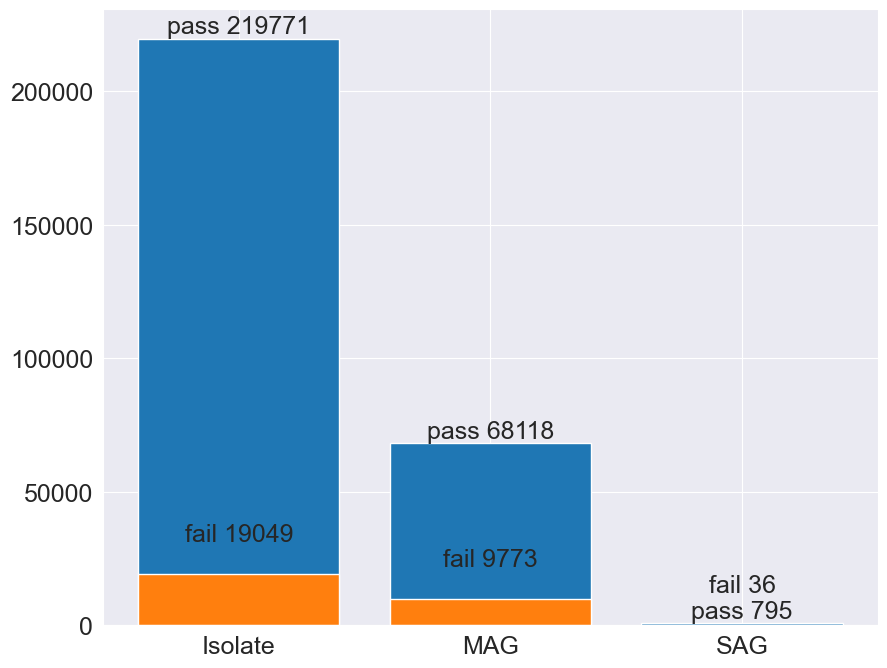

In [9]:
def pass_vs_fail_category():

    # Set masks
    mask_failed_pro = DF['pass.GUNC_pro'] == False
    mask_failed_gtdb = DF['pass.GUNC_gtdb'] == False

    # mask_failed_all = mask_failed_pro | mask_failed_gtdb
    mask_failed_all = mask_failed_gtdb
    mask_pass_all = ~mask_failed_all

    df_failed_all = DF[mask_failed_all]
    df_pass_all = DF[mask_pass_all]

    print(len(df_failed_all))

    all_counts = Counter(df_pass_all['ncbi_genome_category'])
    all_data = {
        'Isolate': all_counts['none'] +  all_counts['derived from environmental sample'],
        # 'ENV': all_counts['derived from environmental sample'],
        'MAG': all_counts['derived from metagenome'],
        'SAG': all_counts['derived from single cell'],
    }

    fail_counts = Counter(df_failed_all['ncbi_genome_category'])
    fail_data = {
        'Isolate': fail_counts['none'] + fail_counts['derived from environmental sample'],
        # 'ENV': fail_counts['derived from environmental sample'],
        'MAG': fail_counts['derived from metagenome'],
        'SAG': fail_counts['derived from single cell'],
    }


    all_data_norm = {k:  v / (v + fail_data[k]) * 100 for k, v in all_data.items()}
    fail_data_norm = {k: v/ (v + all_data[k]) * 100 for k, v in fail_data.items()}

    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots( figsize=(10, 8))

    # ax.set_ylabel('Count')
    # ax.set_xlabel('NCBI Genome Category')
    bars = ax.bar(all_data.keys(), all_data.values(), label='pass')
    fail_bars = ax.bar(fail_data.keys(), fail_data.values(), label='fail')
    plt.bar_label(bars, fmt='pass %g')
    plt.bar_label(fail_bars, padding=20, fmt='fail %g')

    # plt.title('NCBI genome category for GUNC pass/fail genomes')


    plt.rcParams.update({'font.size': 12})
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # plt.savefig('/tmp/category.svg')

    return

pass_vs_fail_category()

In [8]:
def ncbi_assembly_level():
    df_fail = DF[DF['pass.GUNC'] == False]
    df_pass = DF[DF['pass.GUNC'] == True]

    all_counts = Counter(df_pass['ncbi_assembly_level'])
    print(all_counts)
    all_data = {
        'Contig': all_counts['Contig'],
        'Scaffold': all_counts['Scaffold'],
        'Chromosome': all_counts['Chromosome'],
        'Complete Genome': all_counts['Complete Genome'],
        'none': all_counts['none'],
    }

    fail_counts = Counter(df_fail['ncbi_assembly_level'])
    fail_data = {
        'Contig': fail_counts['Contig'],
        'Scaffold': fail_counts['Scaffold'],
        'Chromosome': fail_counts['Chromosome'],
        'Complete Genome': fail_counts['Complete Genome'],
        'none': fail_counts['none'],
    }
    fig, ax = plt.subplots( figsize=(10, 8))

    ax.set_ylabel('Count')
    ax.set_xlabel('NCBI Genome Category')
    bars = ax.bar(all_data.keys(), all_data.values(), label='pass')
    fail_bars = ax.bar(fail_data.keys(), fail_data.values(), label='fail')
    plt.bar_label(bars, fmt='pass %g')
    plt.bar_label(fail_bars, padding=25, fmt='fail %g')

    plt.title('NCBI assembly level for GUNC pass/fail genomes')


    plt.legend()
    plt.show()

    print('pass', all_data)
    print('fail', fail_data)

    return

ncbi_assembly_level()

KeyError: 'pass.GUNC'

In [ ]:
def fail_tax_level():
    df_fail = DF[DF['pass.GUNC'] == False]

    fig, ax = plt.subplots(figsize=(10, 7))
    plt.title('Taxonomic level at which genomes failed GUNC')

    df_counts = Counter(df_fail['taxonomic_level'])
    data = {
        'Genus': df_counts['genus'],
        'Family': df_counts['family'],
        'Order': df_counts['order'],
        'Class': df_counts['class'],
        'Phylum': df_counts['phylum'],
        'Domain': df_counts['kingdom'],
    }

    ax.set_ylabel('Count')
    ax.set_xlabel('Taxonomic level')
    bars = ax.bar(data.keys(), data.values())
    plt.bar_label(bars)

    plt.show()
    return

fail_tax_level()

In [ ]:
def histogram_of_css_scores():

    mask_fail = DF['pass.GUNC'] == False

    df_fail = DF[mask_fail]

    fig, ax = plt.subplots(figsize=(10, 7))
    plt.title('Distribution of maximum CSS for failed genomes')

    sns.histplot(df_fail, x='clade_separation_score', ax=ax)

    ax.set_ylabel('Count')
    ax.set_xlabel('Maximum clade separation score (CSS)')

    plt.show()

    return
histogram_of_css_scores()